# Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Data Sets

The data is contained in three files:

- **portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
- **profile.json** - demographic data for each customer
- **transcript.json** - records for transactions, offers received, offers viewed, and offers completed

### Dataset Schema

**portfolio.json**

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

**profile.json**

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

**transcript.json**

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [3]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Cleaning

In [4]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [5]:
## portfolio dataset
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [204]:
portfolio_clean = portfolio.copy()

In [205]:
portfolio_channels_df = pd.get_dummies(portfolio_clean.channels.apply(pd.Series).stack(),
                             prefix="channel").sum(level=0)

In [206]:
portfolio_clean.rename(columns = {'id':"offer_id"},inplace = True)

In [207]:
portfolio_offers_df = pd.get_dummies(portfolio_clean.offer_type)

In [208]:
portfolio_final = pd.concat([portfolio_clean,portfolio_channels_df,portfolio_offers_df],axis = 1)

In [210]:
portfolio_final.drop('channels',axis = 1,inplace = True)

In [211]:
portfolio_final.head()

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [28]:
## profile dataset 
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [29]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [31]:
profile[profile.age == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [358]:
profile_clean = profile.copy()

In [359]:
profile_clean['valid'] = (profile_clean.age != 118).astype(int)

In [360]:
profile_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
 5   valid             17000 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(2)
memory usage: 730.6+ KB


In [361]:
date = lambda x: pd.to_datetime(str(x) , format = '%Y%m%d')

In [362]:
profile_clean.became_member_on = profile_clean.became_member_on.apply(date)

In [363]:
profile_clean.rename(columns = {'id': 'customer_id'},inplace = True)

In [364]:
profile_clean.head()

,gender,age,customer_id,became_member_on,income,valid
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0


In [365]:
gender_df = pd.get_dummies(profile_clean['gender'],prefix = 'gender')

In [366]:
profile_final = pd.concat([profile_clean,gender_df],axis = 1,sort=False)

In [367]:
#profile_final.drop('gender',axis = 1,inplace=True)

In [368]:
profile_final.reset_index(drop = True,inplace =True)

In [369]:
profile_final.head()

,gender,age,customer_id,became_member_on,income,valid,gender_F,gender_M,gender_O
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,0,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1,0,0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,1,0,0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,0,0


In [60]:
## transcript dataset 
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [61]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [254]:
transcript_offer_id = pd.DataFrame(transcript['value'].values.tolist(), index=transcript.index)

In [255]:
transcript_offer_id['offer id'].isnull().sum()

172532

In [256]:
transcript['value'].isnull().sum()

0

In [257]:
transcript_offer_id.drop(['offer_id',"reward"],axis = 1 , inplace = True)

In [258]:
transcript.rename(columns = {'person':'customer_id'},inplace=True)

In [286]:
transcript_event_df = pd.get_dummies(transcript['event'])

In [287]:
transcript_event_df

,offer completed,offer received,offer viewed,transaction
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
306529,0,0,0,1
306530,0,0,0,1
306531,0,0,0,1
306532,0,0,0,1


In [261]:
transcript_final = pd.concat([transcript,transcript_offer_id,transcript_event_df],axis = 1)

In [262]:
transcript_final.drop("value",axis = 1, inplace=True)

In [263]:
transcript_final.rename(columns = {'offer id':'offer_id'},inplace=True)

In [264]:
transcript_final.head()

,customer_id,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0


In [265]:
transcript_final

,customer_id,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,0,0,0,1


In [266]:
transcript_final['offer_id'].replace(np.nan,"None",inplace = True)

Let's merge all the dataframes into one for analysis. 
This dataframe will have several NaN values in places where that piece of data is not needed. For instance, in the event of an offer reception, 
the transaction value will be NaN. We'll ignore those in our analysis

In [336]:
trans_prof = pd.merge(transcript_final, profile_final, on='customer_id',
                          how="left")

In [337]:
trans_prof

,customer_id,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income,vaild,gender_F,gender_M,gender_O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,F,75,2017-05-09,100000.0,1,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,None,118,2017-08-04,NaN,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,M,68,2018-04-26,70000.0,1,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,None,118,2017-09-25,NaN,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,None,118,2017-10-02,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,0,0,0,1,M,66,2018-01-01,47000.0,1,0,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,0,0,0,1,M,52,2018-04-08,62000.0,1,0,1,0
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,0,0,0,1,F,63,2013-09-22,52000.0,1,1,0,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53,0,0,0,1,M,57,2016-07-09,40000.0,1,0,1,0


In [338]:
df = pd.merge(trans_prof, portfolio_final, on='offer_id', how='left')

In [339]:
df.head()

,customer_id,event,time,offer_id,amount,offer completed,offer received,offer viewed,transaction,gender,...,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,F,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,None,...,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,M,...,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,None,...,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,None,...,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [340]:
df.offer_id

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         0b1e1539f2cc45b7b9fa7c272da2e1d7
2         2906b810c7d4411798c6938adc9daaa5
3         fafdcd668e3743c1bb461111dcafc2a4
4         4d5c57ea9a6940dd891ad53e9dbe8da0
                        ...               
306529                                None
306530                                None
306531                                None
306532                                None
306533                                None
Name: offer_id, Length: 306534, dtype: object

In [341]:
df.offer_id.replace('ae264e3637204a6fb9bb56bc8210ddfd','B1',inplace = True)
df.offer_id.replace('4d5c57ea9a6940dd891ad53e9dbe8da0','B2',inplace = True)
df.offer_id.replace('9b98b8c7a33c4b65b9aebfe6a799e6d9','B3',inplace = True)
df.offer_id.replace('f19421c1d4aa40978ebb69ca19b0e20d','B4',inplace = True)
df.offer_id.replace('0b1e1539f2cc45b7b9fa7c272da2e1d7','D1',inplace = True)
df.offer_id.replace('2298d6c36e964ae4a3e7e9706d1fb8c2','D2',inplace = True)
df.offer_id.replace('fafdcd668e3743c1bb461111dcafc2a4','D3',inplace = True)
df.offer_id.replace('2906b810c7d4411798c6938adc9daaa5','D4',inplace = True)
df.offer_id.replace('3f207df678b143eea3cee63160fa8bed','I1',inplace = True)
df.offer_id.replace('5a8bc65990b245e5a138643cd4eb9837','I2',inplace = True)

In [342]:
df.rename(columns = {"offer completed":"event_offer_completed","offer received":"event_offer_received","offer viewed":"event_offer_viewed"},inplace = True)

In [343]:
df.rename(columns = {"transaction":"event_transaction"},inplace = True)

In [352]:
df.rename(columns = {"vaild":"valid"},inplace = True)

In [353]:
df.head()

,customer_id,event,time,offer_id,amount,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,gender,...,difficulty,duration,offer_type,channel_email,channel_mobile,channel_social,channel_web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,B3,NaN,0,1,0,0,F,...,5.0,7.0,bogo,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,received,0,D1,NaN,0,1,0,0,None,...,20.0,10.0,discount,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,received,0,D4,NaN,0,1,0,0,M,...,10.0,7.0,discount,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,D3,NaN,0,1,0,0,None,...,10.0,10.0,discount,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,received,0,B2,NaN,0,1,0,0,None,...,10.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [345]:
df.event.replace('offer received','received',inplace = True)
df.event.replace('offer viewed','viewed',inplace = True)
df.event.replace('offer completed','completed',inplace = True)

In [346]:
df.event.unique()

array(['received', 'viewed', 'transaction', 'completed'], dtype=object)

## Data Analysis

Check total time for analysis

In [276]:
df.time.max() / 24

29.75

The experiment was run for almost 30 days, and a grand total of 306,534 events were collected.

## Data Visualization

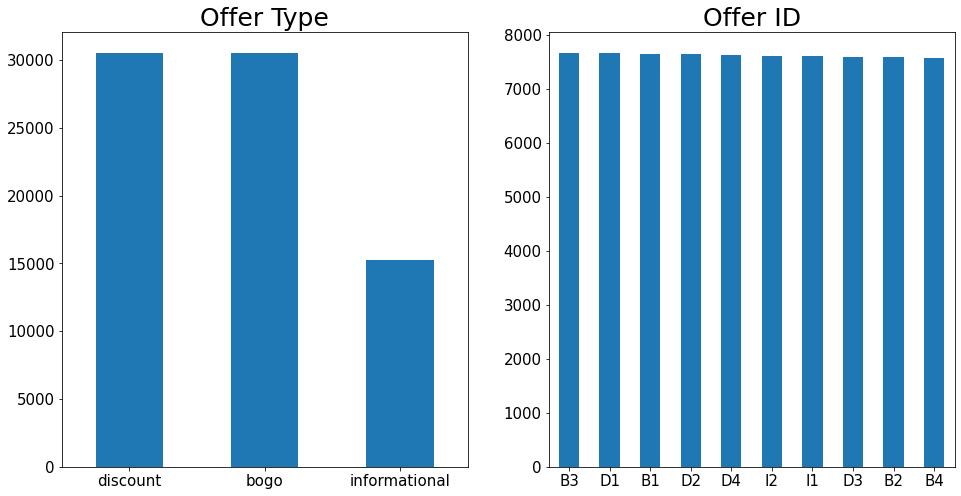

In [277]:
plt.subplot(121)
df[df.offer_received == 1].offer_type.value_counts().plot(kind = 'bar' , figsize = (16,8) , rot = 0)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.title("Offer Type",fontsize= 25)

plt.subplot(122)
df[df.offer_received == 1].offer_id.value_counts().plot(kind = 'bar' , figsize = (16,8) , rot = 0)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.title("Offer ID",fontsize= 25)
plt.show()

In [278]:
df[df.offer_received == 1].offer_id.value_counts()

B3    7677
D1    7668
B1    7658
D2    7646
D4    7632
I2    7618
I1    7617
D3    7597
B2    7593
B4    7571
Name: offer_id, dtype: int64

The simulator use uniform distribution for offers , all offers almost have the same value

In [296]:
def get_offer_cust(df, offer_type=None):
    """
    Get offer data (received, viewed and completed) per customer and
    offer type
    Inputs:
    - df: dataframe of merged transactions, portfolio and profile data
    - offer_type: informational, bogo or discount
    Output:
    - aggregated data per customer and offer type
    """
    data = dict()
    for e in ['received', 'viewed', 'completed']:
        # Informational offers don't have completed data
        if offer_type == 'informational' and e == 'completed':
            continue
        flag = (df['event_offer_{}'.format(e)] == 1)
        key = e
        if offer_type:
            flag = flag & (df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = df[flag].groupby('customer_id').offer_id.count()
    # Informational offers don't have reward data
    flag = (df.event_offer_completed == 1)
    if offer_type != 'informational':
        key = 'reward'
        if offer_type:
            flag = flag & (df.offer_type == offer_type)
            key = '{}_'.format(offer_type) + key
        data[key] = df[flag].groupby('customer_id').reward.sum()

    return data

In [297]:
def get_offer_id_cust(df, offer_id):
    """
    Get offer data (received, viewed and completed) per customer
    and offer id
    Inputs:
    - df: dataframe of merged transactions, portfolio and profile data
    - offer_id: B1, B2, ...
    Output:
    - aggregated data per customer and offer id
    """
    data = dict()

    for e in ['received', 'viewed', 'completed']:
        # Informational offers don't have completed data
        if offer_id in ['I1', 'I2'] and e == 'completed':
            continue
        event = 'event_offer_{}'.format(e)
        flag = (df[event] == 1) & (df.offer_id == offer_id)
        key = '{}_{}'.format(offer_id, e)
        data[key] = df[flag].groupby('customer_id').offer_id.count()

    # Informational offers don't have reward data
    flag = (df.event_offer_completed == 1) & (df.offer_id == offer_id)
    if offer_id not in ['I1', 'I2']:
        key = '{}_reward'.format(offer_id)
        data[key] = df[flag].groupby('customer_id').reward.sum()

    return data

In [312]:
def round_age(x):
    """
    Round age to the 5th of each 10th (15, 25,..., 105)
    Input:
    - x: age
    Output:
    - rounded age. Returns 0 if the value is less than 15 or more than 105
    """
    for y in range(15, 106, 10):
        if x >= y and x < y+10:
            return y
    return 0


In [313]:
def round_income(x):
    """
    Round income to the lower 10000th
    Intput:
    - income
    Output:
    - lower 10000th of the income. Return 0 if the income
    is less than 30,000 or more than 120,000
    """
    for y in range(30, 130, 10):
        if x >= y*1000 and x < (y+10)*1000:
            return y*1000
    return 0

In [298]:
def per_customer_data(df, profile):
    """ Build a dataframe with aggregated purchase and offer data and demographics
    Input:
    - df: merged dataframe with transactions, customer and offer data
    Output:
    - customer: dataframe with aggregated data
    """
    cust_dict = dict()
    # Get total transaction data
    transactions = df[df.event_transaction == 1].groupby('customer_id')
    cust_dict['total_expense'] = transactions.amount.sum()
    cust_dict['total_transactions'] = transactions.amount.count()
    # Get  aggr offer data
    cust_dict.update(get_offer_cust(df))
    # Get offer type data
    for ot in ['bogo', 'discount', 'informational']:
        cust_dict.update(get_offer_cust(df, ot))
    # Get offer id data
    for oi in ['B1', 'B2', 'B3', 'B4', 'D1', 'D2', 'D3', 'D4', 'I1', 'I2']:
        cust_dict.update(get_offer_id_cust(df, oi))

    customers = pd.concat(cust_dict.values(), axis=1, sort=False);
    customers.columns = cust_dict.keys()
    customers.fillna(0, inplace=True)

    # Add demographic data
    customers = pd.merge(customers, profile.set_index('customer_id'),
                         left_index=True, right_index=True)
    customers['age_group'] = customers.age.apply(round_age)
    customers['income_group'] = customers.income.apply(round_income)
    customers['net_expense'] = customers['total_expense'] - customers['reward']

    return customers


This dataframe is intended to aggregate offer and transactional data on a per customer basis. This should facilitate the analysis of each customer's transactional behavior

In [370]:
customers = per_customer_data(df, profile_final)

In [371]:
customers.head(3)

,total_expense,total_transactions,received,viewed,completed,reward,bogo_received,bogo_viewed,bogo_completed,bogo_reward,...,age,became_member_on,income,valid,gender_F,gender_M,gender_O,age_group,income_group,net_expense
0009655768c64bdeb2e877511632db8f,127.60,8.0,5.0,4.0,3.0,0.0,1.0,1.0,0.0,0.0,...,33,2017-04-21,72000.0,1,0,1,0,25,70000,127.60
00116118485d4dfda04fdbaba9a87b5c,4.09,3.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,...,118,2018-04-25,NaN,0,0,0,0,0,0,4.09
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.0,5.0,5.0,3.0,0.0,1.0,1.0,0.0,0.0,...,40,2018-01-09,57000.0,1,0,0,1,35,50000,79.46


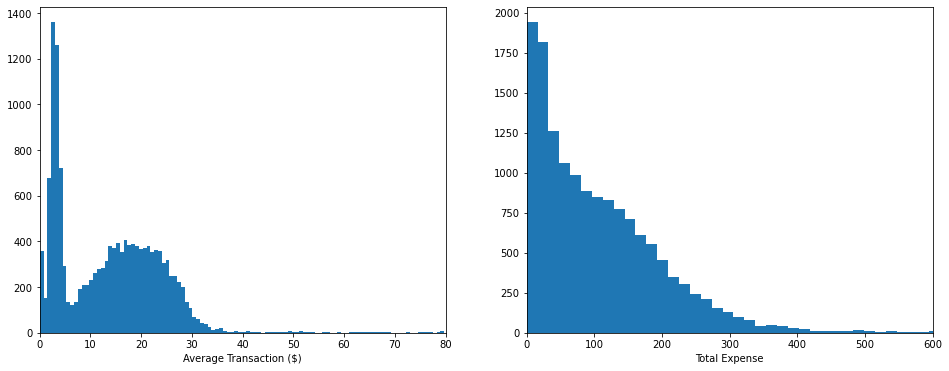

In [372]:
plt.figure(figsize=(16,6))

bins = 600

avg_transaction = customers[customers.valid == 1].total_expense / customers[customers.valid == 1].total_transactions
avg_transaction.fillna(0 , inplace = True)

plt.subplot(121)
plt.hist(avg_transaction , bins)
plt.xlabel("Average Transaction ($)")
ax = plt.gca();
ax.set_xlim(0,80);


bins = 100
plt.subplot(122)
plt.hist(customers[customers.valid == 1].total_expense, bins)
plt.xlabel("Total Expense")
ax = plt.gca();
ax.set_xlim(0,600);

plt.show()

The average transaction value seems to follow a bi-modal distribution, while the total expense an exponential distribution with negative parameter.

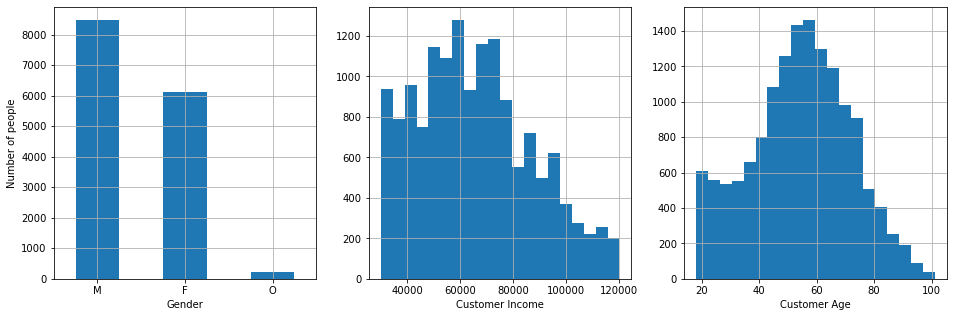

In [374]:
plt.figure(figsize = (16,5))

plt.subplot(131)
profile.gender.value_counts().plot(kind = 'bar' , rot = 0 , figsize = (16,5) , color = 'tab:blue')
plt.ylabel('Number of people')
plt.xlabel('Gender')
plt.grid()

plt.subplot(132)
cust_income = customers[customers.income_group > 0].income
plt.xlabel('Customer Income');
plt.hist(cust_income, 20)
plt.grid()

plt.subplot(133)
cust_age = customers[customers.valid == 1].age
plt.xlabel('Customer Age');
plt.hist(cust_age, 20)
plt.grid()

population distribution by age , income and age the most customer are males . income and age distribution seem to approach normal distribution 

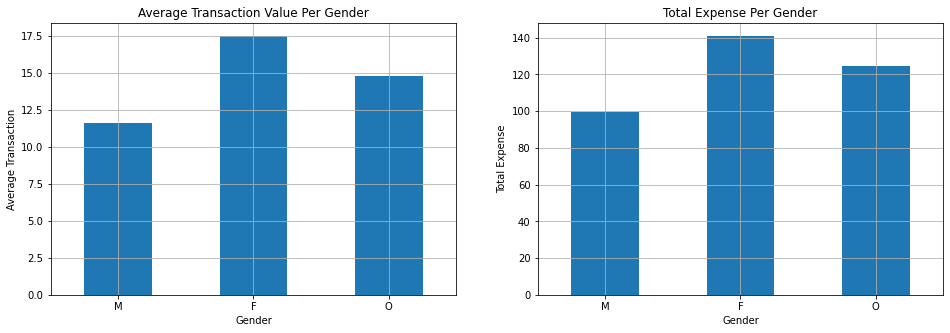

In [375]:
plt.figure(figsize = (16,5))


plt.subplot(121)
gender_group = customers[customers['valid'] == 1].groupby('gender')
gender_transacts = gender_group.total_transactions.sum()
gender_expense = gender_group.total_expense.sum()
(gender_expense / gender_transacts).reindex(['M','F','O']).plot(kind = 'bar',rot = 0)
plt.title('Average Transaction Value Per Gender')
plt.xlabel('Gender')
plt.ylabel('Average Transaction')
plt.grid()

plt.subplot(122)
gender_group.total_expense.mean().reindex(['M','F','O']).plot(kind = 'bar',rot = 0)
plt.title('Total Expense Per Gender')
plt.xlabel('Gender')
plt.ylabel('Total Expense')
plt.grid()

As we see Femals sepnt more money on starbucks products in general and Men spent the least in both metrics.

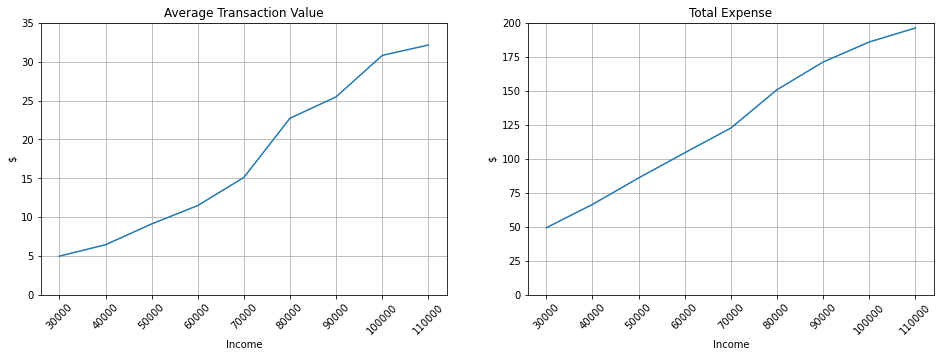

In [382]:
plt.figure(figsize = (16,5))


plt.subplot(121)
income_group = customers[(customers.valid == 1) & (customers.income > 0)].groupby('income')
income_transact = income_group.total_transactions.sum()
income_expense = income_group.total_expense.sum()
ax = (income_expense / income_transact).reindex(range(30000,111000,10000)).plot(kind = 'line',rot = 45)
plt.title('Average Transaction Value')
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 35)


plt.subplot(122)
ax = income_group.total_expense.mean().reindex(range(30000,111000,10000)).plot(kind = 'line',rot = 45)
plt.title('Total Expense')
plt.xlabel('Income')
plt.ylabel('$')
plt.grid()
ax.set_ylim(0, 200)
plt.show()

Expenses and average transaction value grow as the income grows.

Text(0, 0.5, '$')

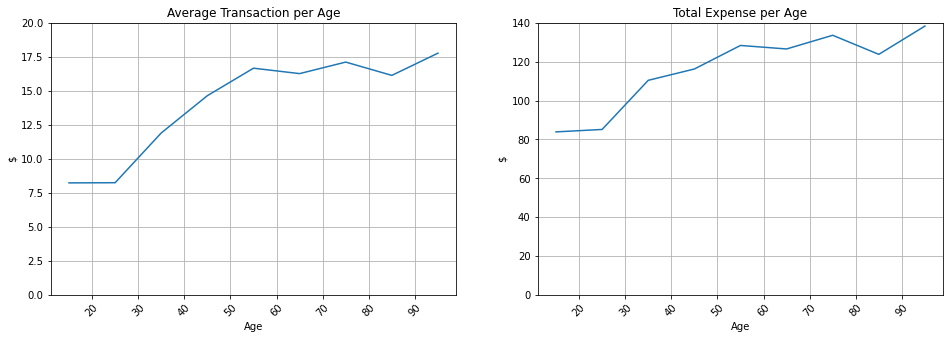

In [385]:
plt.figure(figsize = (16,5))

plt.subplot(121)
age_group = customers[(customers.valid == 1) & (customers.income_group > 0)].groupby('age_group')
transact_group = age_group.total_transactions.sum()
expense_group = age_group.total_expense.sum()
ax = (expense_group / transact_group).reindex(range(15,96,10)).plot(kind = 'line',rot = 45)
plt.title('Average Transaction per Age')
ax.set_ylim(0,20)
plt.grid(True)
plt.xlabel("Age")
plt.ylabel('$')


plt.subplot(122)
ax = age_group.total_expense.mean().reindex(range(15,96,10)).plot(kind = 'line',rot = 45)
plt.title('Total Expense per Age')
ax.set_ylim(0,140)
plt.grid(True)
plt.xlabel("Age")
plt.ylabel('$')

As we see like the plot above as people get older the values of thier transaction and total expense increases.This might be to the fact that there is a direct correlation between age and income.

## Offer Analysis
### Analysis per offer kind